# practice

If you don't have it yet, please <a href="/archive/data/jerusalem2019.csv" download>download here</a> the meteorological data fro 2019 in Jerusalem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
np.random.seed(49)

%matplotlib widget

# White noise
If we randomly draw values from the same distribution we will get white noise.

In [2]:
# generate binary noise random ones and zeroes with equal distribution
n = 1000
binary_noise = np.random.choice([-1, 1], size=n)

# generate gaussian noise with mean 0 and standard deviation 1
gaussian_noise = np.random.normal(0, 1, n)

Text(0.5, 1.0, 'gaussian')

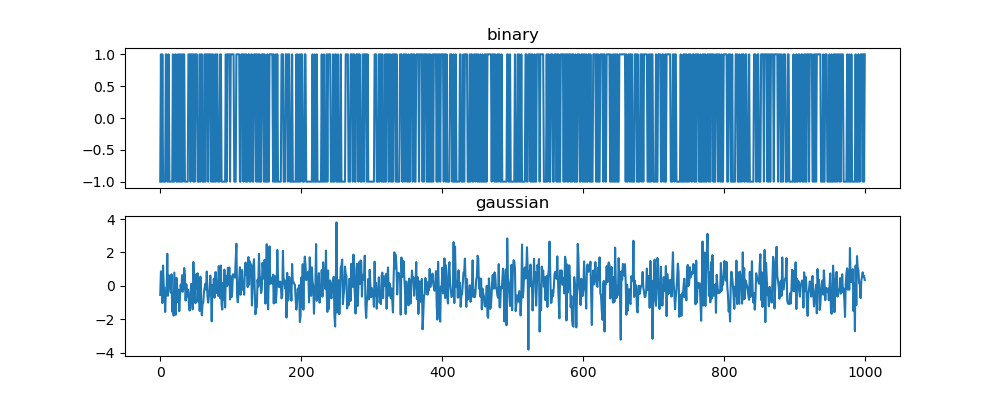

In [3]:
# plot:
fig, ax = plt.subplots(2,1, figsize=(10,4), sharex=True)
ax[0].plot(binary_noise)
ax[0].set_title('binary')

ax[1].plot(gaussian_noise)
ax[1].set_title('gaussian')

# Random walk
If we cumulatively sum the white noise, we then get a random walk

Text(0.5, 1.0, 'walk gaussian')

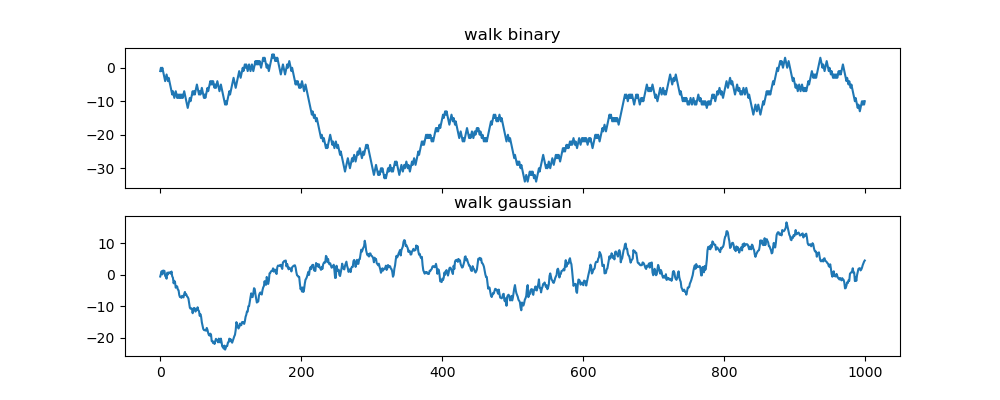

In [4]:
walk_binary = binary_noise.cumsum()
walk_gaussian = gaussian_noise.cumsum()

fig, ax = plt.subplots(2,1, figsize=(10,4), sharex=True)
ax[0].plot(walk_binary)
ax[0].set_title('walk binary')

ax[1].plot(walk_gaussian)
ax[1].set_title('walk gaussian')

## Differencing
Given an array  
$$a = [a_0, a_1, a_2, ..., a_{n-1}]$$ 
the operation performed by `np.diff(a)` can be represented as:  
$$\Delta a = [\Delta a_1, \Delta a_2, ..., \Delta a_{n-1}]$$ 
where  
$$\Delta a_i = a_{i} - a_{i-1} \quad \text{for} \quad i = 1, 2, ..., n-1$$  

**If we difference the random walk we will get the white noise.**

(0.0, 100.0)

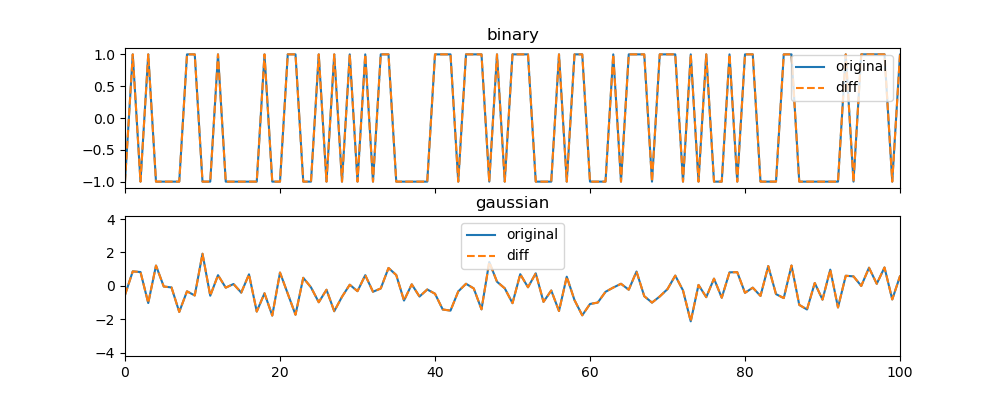

In [5]:
fig, ax = plt.subplots(2,1, figsize=(10,4), sharex=True)
ax[0].plot(binary_noise, label='original')
ax[0].plot(np.diff(walk_binary, prepend=0), label='diff', linestyle='--')
ax[0].set_title('binary')
ax[0].legend()
ax[0].set_xlim(0,100)

ax[1].plot(gaussian_noise, label='original')
ax[1].plot(np.diff(walk_gaussian, prepend=0), label='diff', linestyle='--')
ax[1].set_title('gaussian')
ax[1].legend()
ax[1].set_xlim(0,100)

Another way of understanding this: the python operations `cumsum` and `diff` are each other's inverse.

# AR(1)
$$
X_{t} = \phi\,X_{t-1} + \varepsilon.
$$

This is called an Autoregressive Process of order 1, or AR(1). Here, the current value $X_{t}$ is dependent on the immediately preceding value $X_{t-1}$.

Text(0.5, 1.0, 'AR(1)\t$\\Phi=0.9$')

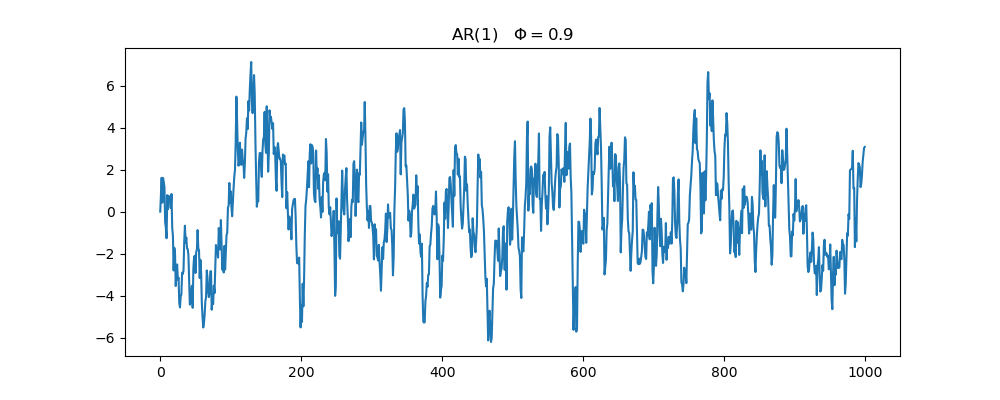

In [6]:
#  initialize time series array
ar1_series = np.zeros(n)

# set a phi value, in addition to this value you should try phi>1 or phi=0
phi = 0.9

for i in range(1, n):
    ar1_series[i] = phi*ar1_series[i-1] + gaussian_noise[i]

# plot:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ar1_series)
ax.set_title(f'AR(1)\t$\Phi={phi}$')

## AR(p)

The next thing to do is to generalize, and define an autoregressive process that depends on $p$ previous states:

$$
x_{t} = \phi_1\,x_{t-1} + \phi_2\,x_{t-2} + \cdots + \phi_p\,x_{t-p} + \varepsilon
$$

In [7]:
# Function to generate AR(p) time series
# this function can recive p as an integer and then is will draw random phi values
# or, you can pass p as a np array of the specific phi values you want.
def generate_ar(n, p):
    # Check if p is an integer or an array
    if isinstance(p, int):
        # Generate random coefficients between -1 and 1
        phi = np.random.uniform(-1, 1, size=p)
    elif isinstance(p, np.ndarray):
        phi = p  # Use the provided array as coefficients
    else:
        raise ValueError("p should be either an integer or a NumPy array")
    
    print(phi)
    # Generate white noise
    noise = np.random.normal(0, 1, n)
    
    # Initialize time series array
    ar_series = np.zeros(n)
    
    for i in range(phi.size, n):
        ar_series[i] = np.dot(phi, ar_series[i-phi.size:i]) + noise[i]
    
    return ar_series

[-0.82679831 -0.50310415 -0.68089179  0.1555622 ]


Text(0.5, 1.0, 'AR(4)')

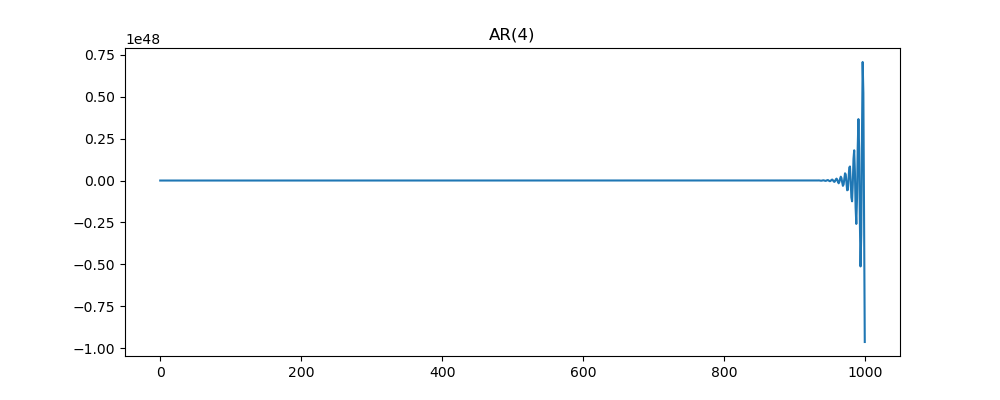

In [8]:
# plot using p as an int
p = 4
ar = generate_ar(n, p)
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ar)
ax.set_title(f'AR({p})')

### using specific $\phi$ values
In the cell below we can specify specific $\phi$ values.  
Use the [interactive tool](https://yairmau.com/time-series/stationarity/stationarity.html#stationarity-of-ar2) from our website to chose the right values.  
Remember, if one of the roots is inside the unit circle, the series will be **not** stationary.


[-0.97 -1.88]


Text(0.5, 1.0, 'AR([-0.97 -1.88])')

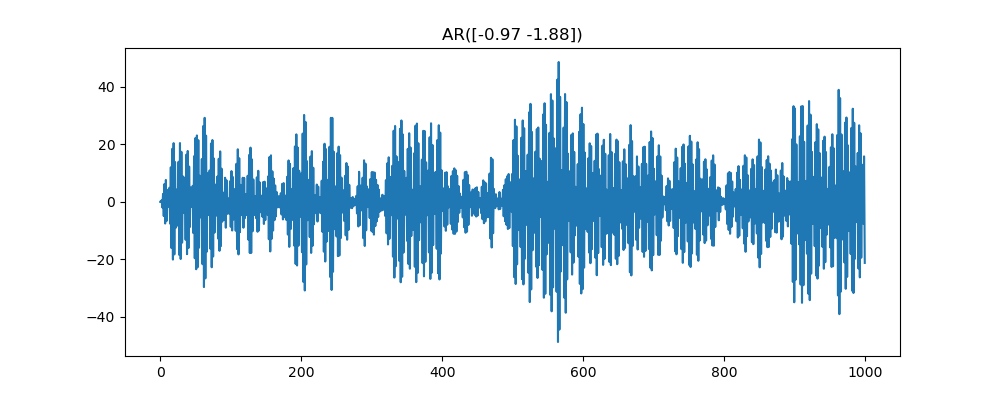

In [9]:
# plot using p as an array of phi values
# the order should be [phi2, phi1]
p = np.array([-0.97,-1.88])
# p = np.array([-1.88,-0.97])

ar2 = generate_ar(n, p)
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(ar2)
ax.set_title(f'AR({p})')

### Weak stationarity
1. its mean $\mu$ does not vary in time:
   $$
   \mu_X(t) = \mu_X(t+\tau)
   $$
   for all values of $t$ and $\tau$.
1. its variance is finite for any time $t$:
   $$
   \sigma^2_X(t) < \infty.
   $$
1. The autocorrelation function between two lagged versions of the same time series, $X(t_1)$ and $X(t_2)$, depends only on the difference $\tau=t_2-t_1$.  
  
  
Let's get a feeling by plotting

In [10]:
def test_stationarity(time_series, window=100):
    series = pd.Series(time_series)
    rolling_var = series.rolling(window=window, center=True).std()**2
    rolling_mean = series.rolling(window=window, center=True).mean()

    fig, ax = plt.subplots(2,1, figsize=(10,4), sharex=True)
    ax[0].plot(series, label='series')
    ax[0].plot(rolling_mean, c='r', label='mean')
    ax[0].legend()
    ax[0].set_title('rolling mean')

    ax[1].plot(rolling_var)
    ax[1].set_title('rolling variance')

    return

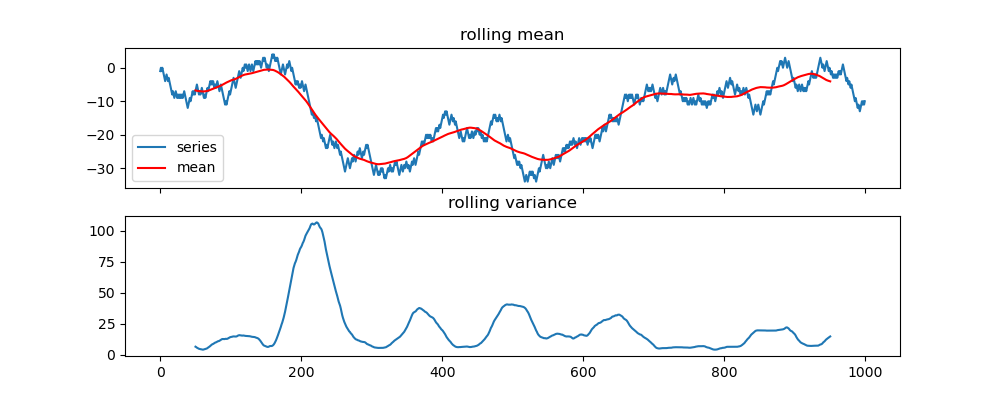

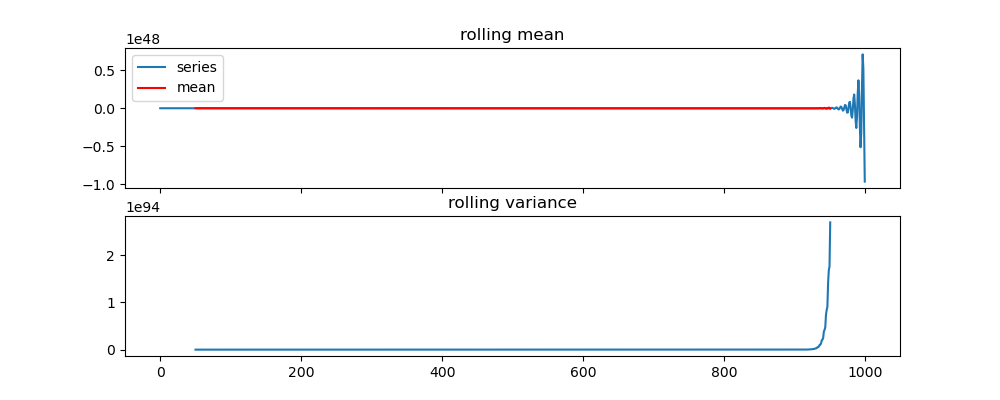

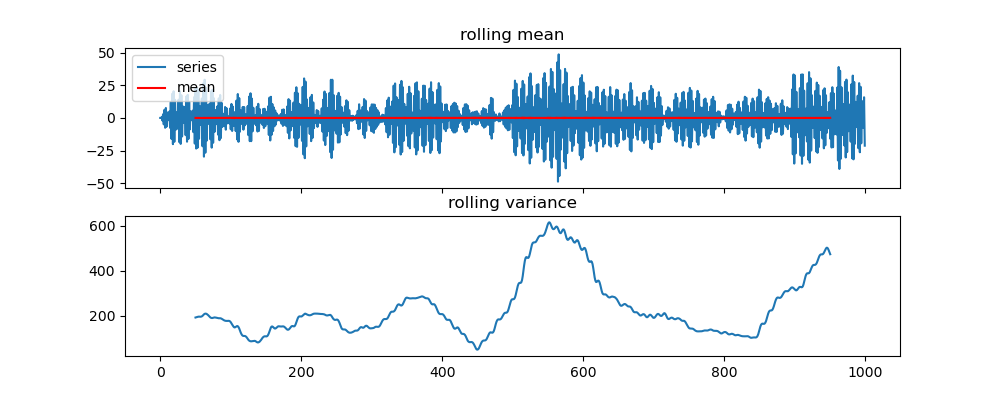

In [11]:
test_stationarity(walk_binary)
# test_stationarity(walk_gaussian)
# test_stationarity(ar1_series)
test_stationarity(ar)
test_stationarity(ar2)

# ACF

In [12]:
def compute_acf(series):
    N = len(series)
    lags = np.arange(N)
    acf = np.zeros_like(lags)
    series = (series - series.mean()) / series.std()
    for i in lags:
        acf[i] = np.sum(series[i:] * series[:N-i])
    acf = acf / N
    return lags, acf

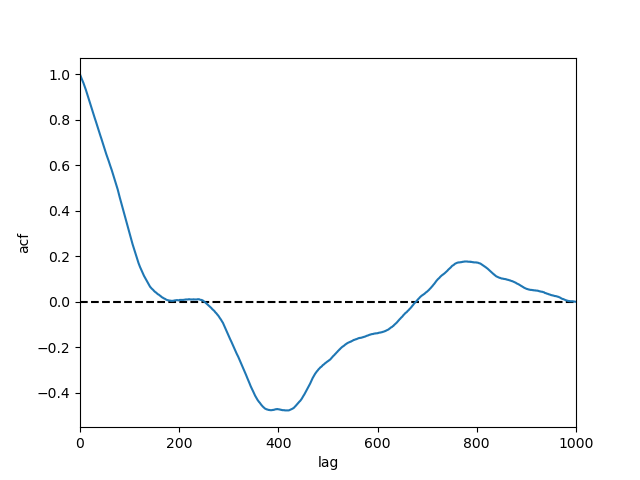

In [13]:
# walk_binary, walk_gaussian, ar1_series, ar, ar2
series_to_plot = walk_binary
fig, ax = plt.subplots()
lags, acf = compute_acf(series_to_plot)
ax.plot([0, n], [0]*2, color="black", ls="--")
ax.plot(lags, acf)
ax.set(xlabel="lag",
       ylabel="acf",
       xlim=[0, n]);

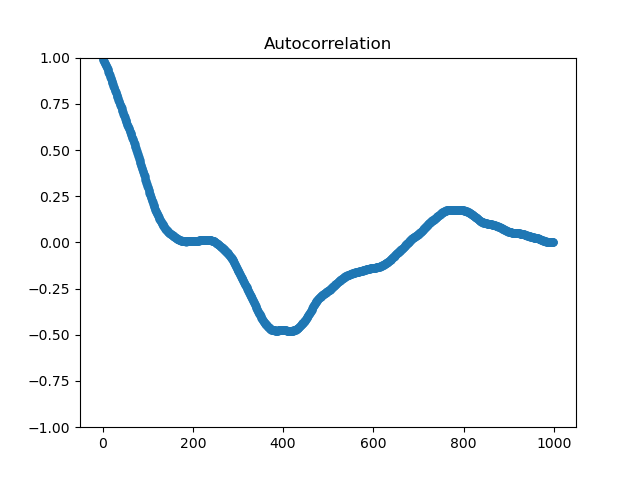

In [14]:
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(series_to_plot, lags= n-1, ax=ax, label="statsmodels", alpha=None, use_vlines=False);

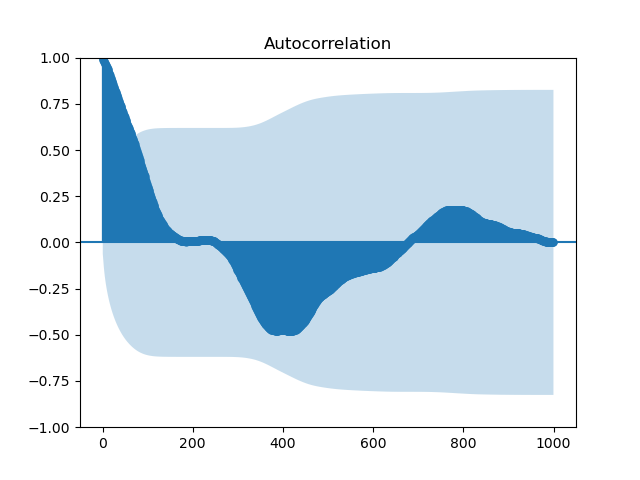

In [15]:
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(series_to_plot, lags= n-1, ax=ax, alpha=.05);

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


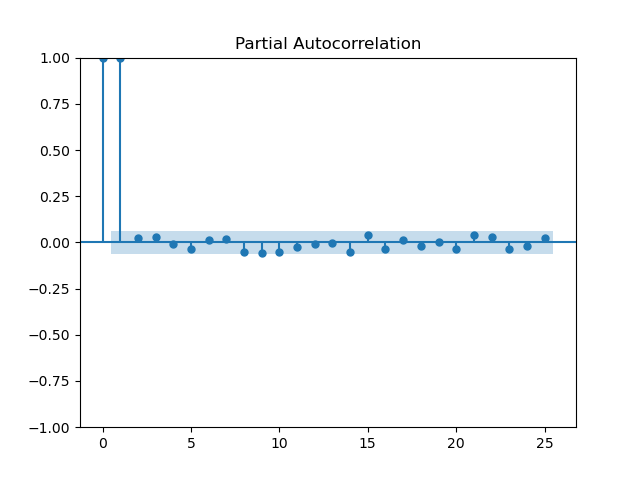

In [16]:
fig, ax = plt.subplots()
sm.graphics.tsa.plot_pacf(series_to_plot, lags=25, ax=ax, alpha=.05);


## Now let's work with actual data

In [17]:
filename = "jerusalem2019.csv"
df = pd.read_csv(filename, na_values=['-'])
df.rename(columns={'Temperature (°C)': 'temperature',
                   'Rainfall (mm)': 'rain'}, inplace=True)
df['date'] = pd.to_datetime(df['Date & Time (Winter)'], dayfirst=True)
df = df.set_index('date')
df = df.fillna(method='ffill')
df

,Station,Date & Time (Winter),Diffused radiation (W/m^2),Global radiation (W/m^2),Direct radiation (W/m^2),Relative humidity (%),temperature,Maximum temperature (°C),Minimum temperature (°C),Wind direction (°),Gust wind direction (°),Wind speed (m/s),Maximum 1 minute wind speed (m/s),Maximum 10 minutes wind speed (m/s),Time ending maximum 10 minutes wind speed (hhmm),Gust wind speed (m/s),Standard deviation wind direction (°),rain
date,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,Jerusalem Givat Ram,01/01/2019 00:00,0.0,0.0,0.0,80.0,8.7,8.8,8.6,75.0,84.0,3.3,4.3,3.5,23:58,6.0,15.6,0.0
2019-01-01 00:10:00,Jerusalem Givat Ram,01/01/2019 00:10,0.0,0.0,0.0,79.0,8.7,8.8,8.7,74.0,82.0,3.3,4.1,3.3,00:01,4.9,14.3,0.0
2019-01-01 00:20:00,Jerusalem Givat Ram,01/01/2019 00:20,0.0,0.0,0.0,79.0,8.7,8.8,8.7,76.0,82.0,3.2,4.1,3.3,00:19,4.9,9.9,0.0
2019-01-01 00:30:00,Jerusalem Givat Ram,01/01/2019 00:30,0.0,0.0,0.0,79.0,8.7,8.7,8.6,78.0,73.0,3.6,4.2,3.6,00:30,5.2,11.7,0.0
2019-01-01 00:40:00,Jerusalem Givat Ram,01/01/2019 00:40,0.0,0.0,0.0,79.0,8.6,8.7,8.5,80.0,74.0,3.6,4.4,3.8,00:35,5.4,10.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 22:20:00,Jerusalem Givat Ram,31/12/2019 22:20,0.0,0.0,1.0,81.0,7.4,7.6,7.3,222.0,255.0,0.5,0.9,1.0,22:11,1.0,47.9,0.0
2019-12-31 22:30:00,Jerusalem Givat Ram,31/12/2019 22:30,0.0,0.0,1.0,83.0,7.3,7.4,7.3,266.0,259.0,0.6,0.8,0.6,22:28,1.1,22.8,0.0
2019-12-31 22:40:00,Jerusalem Givat Ram,31/12/2019 22:40,0.0,0.0,1.0,83.0,7.5,7.6,7.3,331.0,317.0,0.5,0.8,0.6,22:35,1.0,31.6,0.0


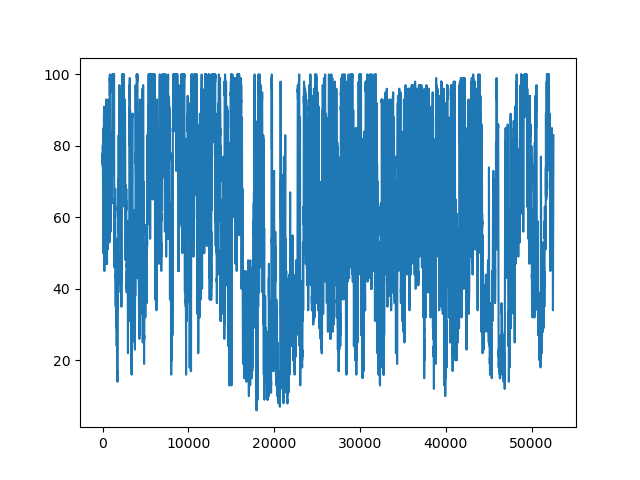

In [18]:
# t = df['temperature'].values
t = df['Relative humidity (%)'].values
# t = df['Wind speed (m/s)'].values
# t = df['Wind direction (°)'].values
fig, ax = plt.subplots()
ax.plot(t)

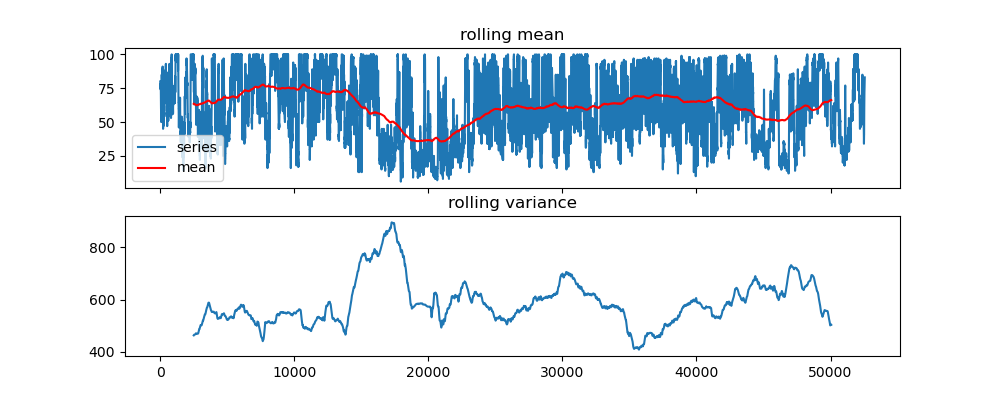

In [19]:
test_stationarity(t, window=5000)

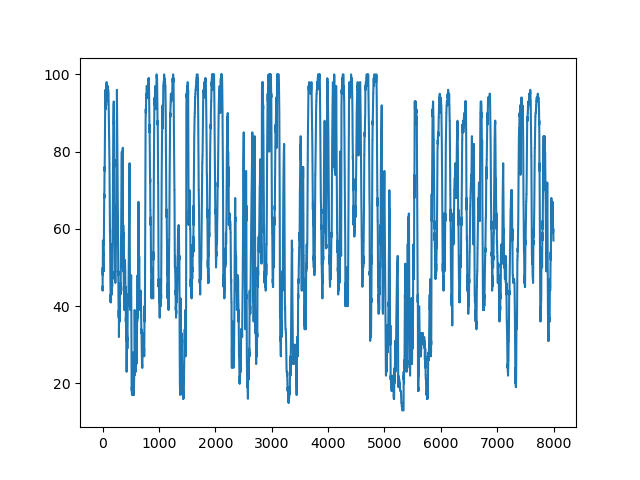

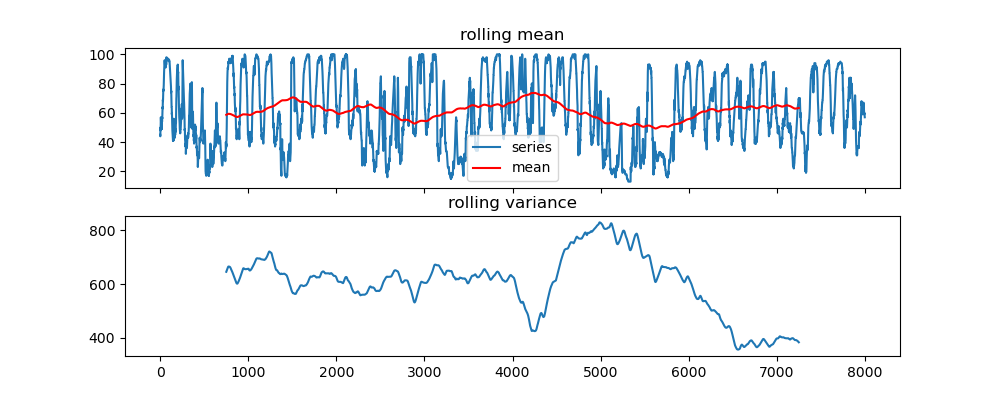

In [20]:
t_stationary = t[27000:35000]
fig, ax = plt.subplots()
ax.plot(t_stationary)
test_stationarity(t_stationary, window=1500)

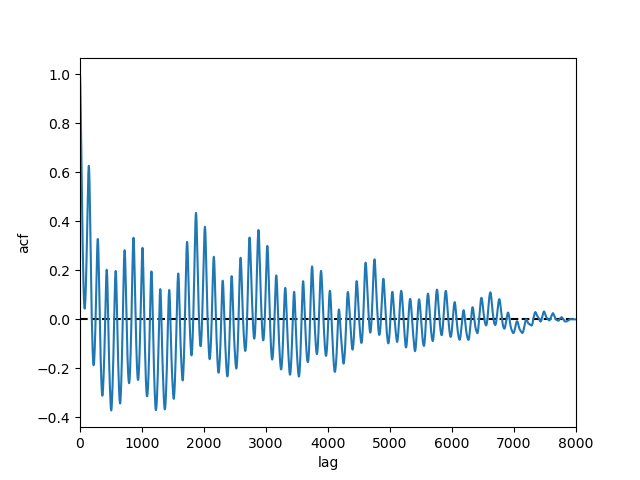

In [21]:
series_to_plot = t_stationary
fig, ax = plt.subplots()
lags, acf = compute_acf(series_to_plot)
ax.plot([0, len(series_to_plot)], [0]*2, color="black", ls="--")
ax.plot(lags, acf)
ax.set(xlabel="lag",
       ylabel="acf",
       xlim=[0, len(series_to_plot)]);

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


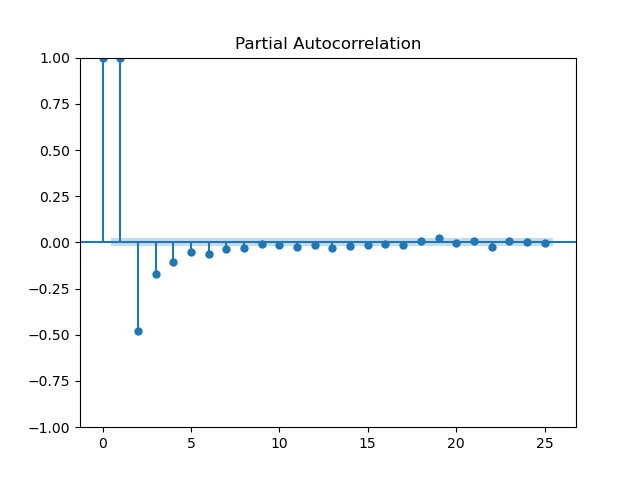

In [22]:
fig, ax = plt.subplots()
sm.graphics.tsa.plot_pacf(series_to_plot, lags=25, ax=ax, alpha=.05);